# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
try:
  import google.colab
  from google.colab import drive
  drive.mount('/gdrive')
  %cd "/gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 1"
  IN_COLAB = True
except:
  IN_COLAB = False

print("Using Colab: ", IN_COLAB)

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 1
Using Colab:  True


In [2]:
!pip install pydot
!pip install pydotplus
!pip install graphviz
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 57.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras_cv as kcv

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

Data is loaded from the filtered, pre-processed and augmented dataset.

The loaded dataset contains both the training and the validation sets, already splitted, thus there is no need to split them again.

Moreover, the images contained in the dataset are already normalized in a range [0, 1], while the labels are already one-hot encoded.

For more details, we'll invite you to have a look to the `Preprocessing.ipynb` and the `CreateTheBestDataset.ipynb` notebooks, respectively in this order.

In [4]:
# Import training and validation datasets
dataset_path = 'last_dataset.npz'
train_val_data = np.load(dataset_path)

# Load training and validation datasets
X_train = train_val_data['images_t']
y_train = train_val_data['labels_t']
X_val = train_val_data['images_v']
y_val = train_val_data['labels_v']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

In [5]:
# Show some images from the augmented training set
num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)
print(random_indices)

fig, axes = plt.subplots(2, num_img // 2, figsize=(96, 96))

for i in range(len(random_indices)):
    title = 'True label: ' + str(y_train[i]) + ' index: ' + str(i)
    ax = axes[i%2, i%num_img//2]
    ax.set_title(title)
    ax.imshow(X_train[i], vmin=0, vmax=255)
    ax.axis('off')
plt.tight_layout()
plt.show()

[34577, 20774, 35863, 44148, 32872, 4682, 26948, 45079, 3921, 27309]


## 🛠️ Transfer Learning

In this part of the model, we want to first use a pre-trained model of the ConvNeXt family to perform transfer learning, using the convolutional layers already provided.

In [6]:
# Define network hyperparameters
batch_size = 32
epochs = 20
learning_rate = 0.001

In [7]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[-1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [8]:
# Initialise ConvNeXt model with pretrained weights, for transfer learning
mobilenet = tfk.applications.MobileNetV3Large (
    include_top = False,              # Exploit only the FEN
    include_preprocessing = True,     # Normalize images
    weights = "imagenet",             # Initialize the weights
    input_shape = input_shape,        # Set the initial dimension
    pooling = 'avg',                  # Global Average Pooling
    name="MobileNetV3Large"
)
# Freeze all layers in ConvNeXt to use it solely as a feature extractor
mobilenet.trainable = False

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the feature extractor
x = mobilenet(inputs)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.5, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(output_shape, activation='softmax', name='dense_1')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and AdamW optimiser
tl_model.compile (
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer = tfk.optimizers.AdamW(learning_rate),
    metrics=['accuracy']
)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 960)                 │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation (Activation)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 48, 48, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu (ReLU)                    │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project (Conv2D)  │ (None, 48, 48, 16)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project_bn        │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_add (Add)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand (Conv2D) │ (None, 48, 48, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand_bn       │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_1 (ReLU)                  │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_depthwise_pad   │ (None, 49, 49, 64)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_depthwise       │ (None, 24, 24, 64)          │             576 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

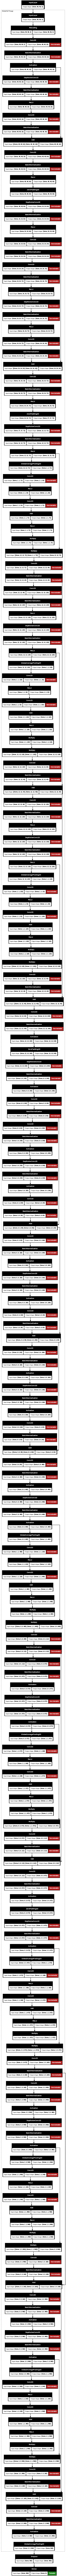

In [10]:
# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [11]:
# Define callbacks
# Early stopping callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = 5,
    restore_best_weights = True
)

# Reduce LR on plateau
reduce_lr = tfk.callbacks.ReduceLROnPlateau (
    monitor = 'val_accuracy',
    mode = 'max',
    factor = 0.1,
    patience = 3
)

callbacks = [early_stopping, reduce_lr]

In [12]:
# Train the model
# As written on Keras docs, the input is expected in a format of a range between 0 and 255
tl_history = tl_model.fit (
    x = X_train*255,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val*255, y_val),
    callbacks = callbacks
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy_tl = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy_tl}%')

# Save the trained model to a file, including final accuracy in the filename
tl_model_filename = 'mobilenet_base_tl.keras'
tl_model.save(tl_model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.4484 - loss: 1.6188 - val_accuracy: 0.7191 - val_loss: 0.8311 - learning_rate: 0.0010
Epoch 2/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5860 - loss: 1.1643 - val_accuracy: 0.7225 - val_loss: 0.8187 - learning_rate: 0.0010
Epoch 3/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5877 - loss: 1.1538 - val_accuracy: 0.7160 - val_loss: 0.8137 - learning_rate: 0.0010
Epoch 4/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5916 - loss: 1.1508 - val_accuracy: 0.7169 - val_loss: 0.8157 - learning_rate: 0.0010
Epoch 5/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5900 - loss: 1.1492 - val_accuracy: 0.7248 - val_loss: 0.8006 - learning_rate: 0.0010
Epoch 6/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5908 - loss: 1.1468 - val_accuracy: 0.7200 - val_loss: 0.8023 - learning_rate: 0.0010
Epoch 7/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Accuracy score over the validation set: 0.7425
Precision score over the validation set: 0.7429
Recall score over the validation set: 0.7425
F1 score over the validation set: 0.742


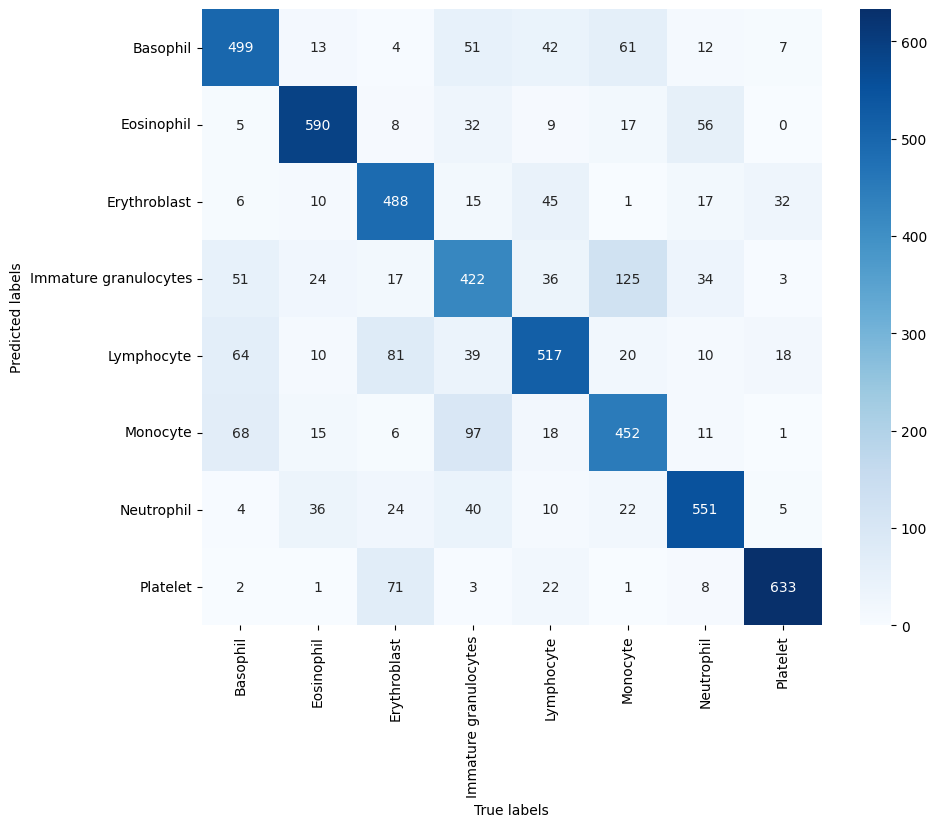

In [13]:
# Load the saved model
tl_model = tfk.models.load_model('mobilenet_base_tl.keras')

# Compute the confusion matrix
predictions = tl_model.predict(X_val*255)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Calculate and display validation set accuracy
tl_accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the validation set: {round(tl_accuracy, 4)}')

# Calculate and display validation set precision
tl_precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the validation set: {round(tl_precision, 4)}')

# Calculate and display validation set recall
tl_recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the validation set: {round(tl_recall, 4)}')

# Calculate and display validation set F1 score
tl_f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the validation set: {round(tl_f1, 4)}')

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 🛠️ Fine Tuning

After having trained the model on the pure ConvNeXt network, we can better adjust the weights via fine-tuning.

In [14]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('mobilenet_base_tl.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display the model architecture
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 960)                 │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation (Activation)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 48, 48, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu (ReLU)                    │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project (Conv2D)  │ (None, 48, 48, 16)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project_bn        │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_add (Add)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand (Conv2D) │ (None, 48, 48, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand_bn       │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_1 (ReLU)                  │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_depthwise_pad   │ (None, 49, 49, 64)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_depthwise       │ (None, 24, 24, 64)          │             576 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,019,418 (11.52 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 15,378 (60.07 KB)

In [15]:
# Get the name of the Transfer Learning layer
tl_layer_name = 'MobileNetV3Large'

# Set the ConvNeXt model layers as trainable
ft_model.get_layer(tl_layer_name).trainable = True

# Set all ConvNeXt layers as non-trainable
for layer in ft_model.get_layer(tl_layer_name).layers:
    layer.trainable = False

# Set the number of layers to maintain frozen
N = 59

# Set the last layers as trainable
for i, layer in enumerate(ft_model.get_layer(tl_layer_name).layers[N:]):
    # Leave BatchNormalization layer frozen, if present
    if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer(tl_layer_name).layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
# ft_model.summary(expand_nested=True)

0 input_layer False
1 rescaling False
2 conv False
3 conv_bn False
4 activation False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_bn False
7 re_lu False
8 expanded_conv_project False
9 expanded_conv_project_bn False
10 expanded_conv_add False
11 expanded_conv_1_expand False
12 expanded_conv_1_expand_bn False
13 re_lu_1 False
14 expanded_conv_1_depthwise_pad False
15 expanded_conv_1_depthwise False
16 expanded_conv_1_depthwise_bn False
17 re_lu_2 False
18 expanded_conv_1_project False
19 expanded_conv_1_project_bn False
20 expanded_conv_2_expand False
21 expanded_conv_2_expand_bn False
22 re_lu_3 False
23 expanded_conv_2_depthwise False
24 expanded_conv_2_depthwise_bn False
25 re_lu_4 False
26 expanded_conv_2_project False
27 expanded_conv_2_project_bn False
28 expanded_conv_2_add False
29 expanded_conv_3_expand False
30 expanded_conv_3_expand_bn False
31 re_lu_5 False
32 expanded_conv_3_depthwise_pad False
33 expanded_conv_3_depthwise False
34 expanded_conv_3_depthwise_bn

In [16]:
# Define fine-tuning network hyperparameters
batch_size = 32
epochs = 20
learning_rate = 1e-4

In [17]:
# Compile the model with a lower learning rate
ft_model.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=['accuracy']
)

In [18]:
# Define callbacks for fine-tuning model
# Early stopping callbacks
early_stopping_ft = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = 5,
    restore_best_weights = True
)

# Reduce LR on plateau
reduce_lr_ft = tfk.callbacks.ReduceLROnPlateau (
    monitor = 'val_accuracy',
    mode = 'max',
    factor = 0.1,
    patience = 3
)

callbacks_ft = [early_stopping_ft, reduce_lr_ft]

In [19]:
# Train the model
ft_history = ft_model.fit (
    x = X_train*255,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val*255, y_val),
    callbacks = callbacks_ft
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy_ft = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy_ft}%')

# Save the trained model to a file, including final accuracy in the filename
ft_model_filename = 'mobilenetv3_ft.keras'
ft_model.save(ft_model_filename)

# Free memory by deleting the model instance
del ft_model

Epoch 1/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.7737 - loss: 0.6413 - val_accuracy: 0.9115 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 2/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8989 - loss: 0.2842 - val_accuracy: 0.9176 - val_loss: 0.2490 - learning_rate: 1.0000e-04
Epoch 3/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9344 - loss: 0.1875 - val_accuracy: 0.9322 - val_loss: 0.2172 - learning_rate: 1.0000e-04
Epoch 4/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9551 - loss: 0.1277 - val_accuracy: 0.9258 - val_loss: 0.2564 - learning_rate: 1.0000e-04
Epoch 5/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9663 - loss: 0.0953 - val_accuracy: 0.9310 - val_loss: 0.2605 - learning_rate: 1.0000e-04
Epoch 6/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9767 - loss: 0.0659 - val_accuracy: 0.9304 - val_loss: 0.2911 - learning_rate: 1.0000e-04
Epoch 7/20
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 18s

175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy score over the validation set: 0.9487
Precision score over the validation set: 0.9489
Recall score over the validation set: 0.9487
F1 score over the validation set: 0.9488


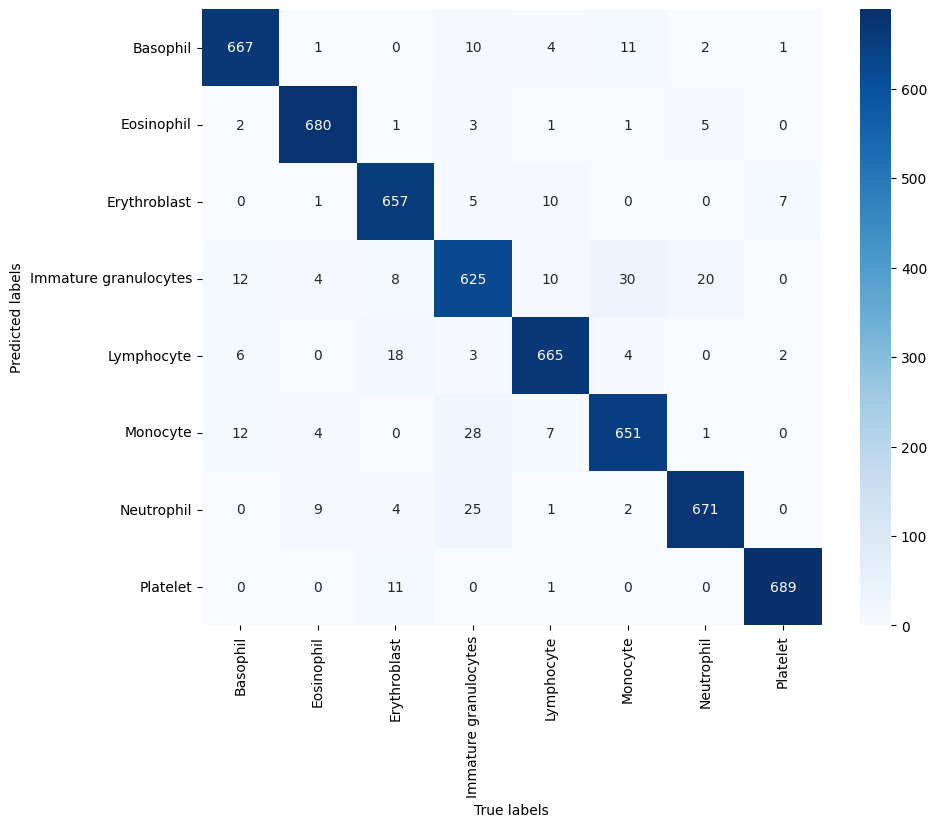

In [20]:
# Load the saved model
ft_model = tfk.models.load_model('mobilenetv3_ft.keras')

# Compute the confusion matrix
predictions = ft_model.predict(X_val*255)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Calculate and display validation set accuracy
ft_accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the validation set: {round(ft_accuracy, 4)}')

# Calculate and display validation set precision
ft_precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the validation set: {round(ft_precision, 4)}')

# Calculate and display validation set recall
ft_recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the validation set: {round(ft_recall, 4)}')

# Calculate and display validation set F1 score
ft_f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the validation set: {round(ft_f1, 4)}')

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

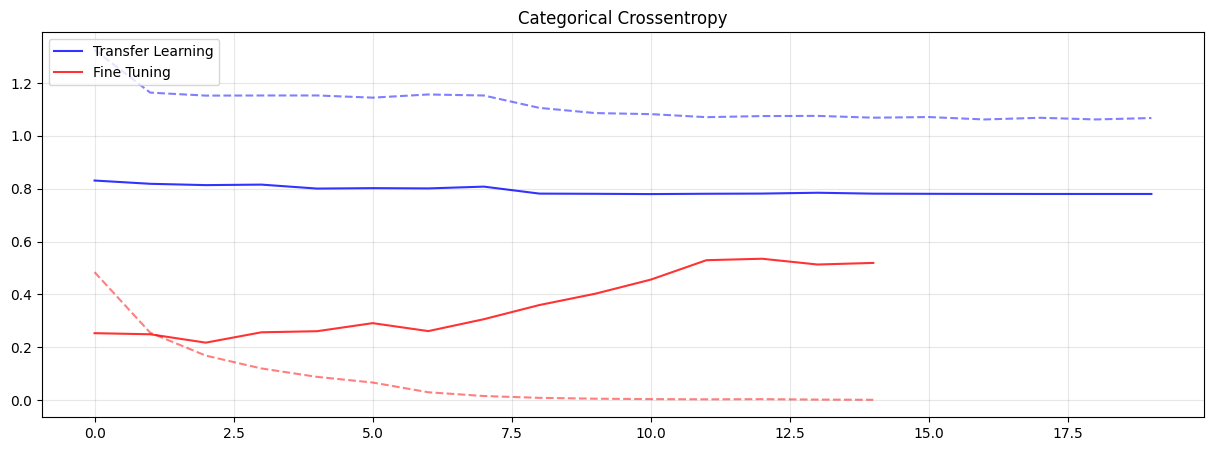

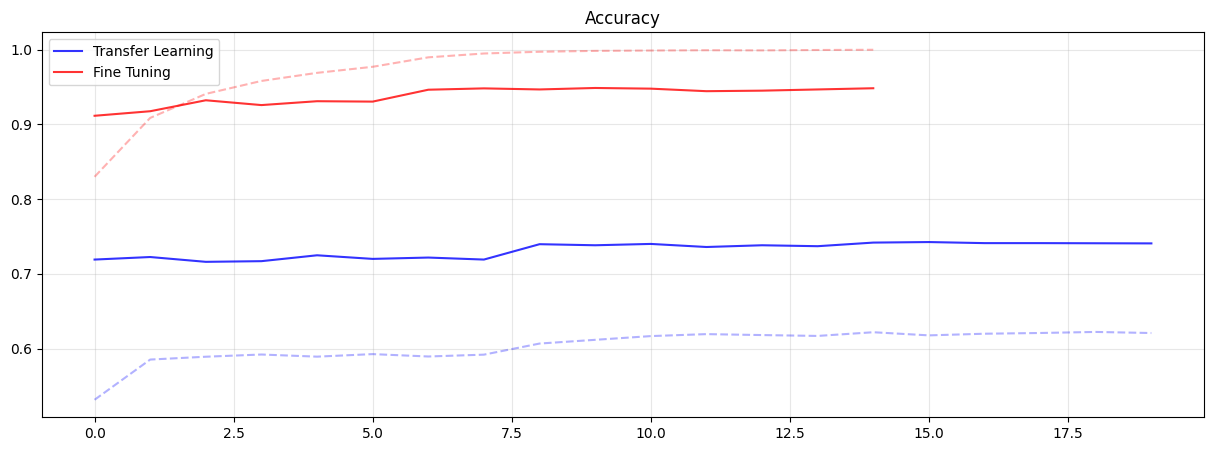

In [21]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15, 5))
plt.plot(tl_history['loss'], alpha=0.5, color='blue', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='blue')
plt.plot(ft_history['loss'], alpha=0.5, color='red', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='red')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=0.3, color='blue', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='blue')
plt.plot(ft_history['accuracy'], alpha=0.3, color='red', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='red')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```


In [22]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('mobilenetv3_ft.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [23]:
# This flag is set to 'False' by default to manually download the files and create the zip
# otherwise precious resources on Colab are going to be wasted.
download_zip = False

In [24]:
if download_zip:
  filename = f'convnext_base_ft.zip'

  if IN_COLAB:
    # Add files to the zip command if needed
    !zip {filename} model.py convnext_large_ft.keras

    from google.colab import files
    files.download(filename)

  else:
    # Create the .zip file to be submitted
    import os
    import zipfile

    # Check if model.py and weights.keras exist
    if os.path.exists("model.py") and os.path.exists(model_filename):
        # Create a ZIP file containing model.py and weights.keras
        with zipfile.ZipFile("sub.zip", "w") as model_zip:
            model_zip.write("model.py")
            model_zip.write(model_filename)
        print("model.zip has been created successfully.")
    else:
        print("model.py or weights.keras not found. Please ensure both files are in the current directory.")